## Introduction

This is a quick and dirty notebook to detect VDSL interference in amateur radio bands. The DSP very closly follows Dr Martin Sach's fantastic article on [VDSL2 Detection](http://rsgb.org/main/files/2018/10/VDSL-Radiation-and-its-Signal-Charecterisation.pdf). The purpose of this notebook is not to replace Lelantos but to offer a way for folks to gain a deeper understanding of the DSP approach and to tinker with the parameters to see their effects. Suggestions, pull requests, critiques etc are very welcome. Happy VDSL hunting.

## Dependencies
This notebook is dependent on siglib, and matplotlib. Installing siglib will pickup numpy

In [1]:
!pip install git+git://github.com/kyjohnso/siglib
!pip install -U matplotlib

  Cloning git://github.com/kyjohnso/siglib to /tmp/pip-req-build-2nrdo5u3
  Running command git clone -q git://github.com/kyjohnso/siglib /tmp/pip-req-build-2nrdo5u3
You should consider upgrading via the '/home/kyjohnso/projects/vdsl/venv/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: matplotlib in ./venv/lib/python3.6/site-packages (3.2.1)
You should consider upgrading via the '/home/kyjohnso/projects/vdsl/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import wave

import matplotlib.pyplot as plt

import siglib as sl

## Read IQ File
This notebook is dependent on getting your IQ file into a 1D numpy.ndarray named x. I grabbed the example file [here](https://rsgb.services/public/software/lelantos/Example_11to13MHz.wav) but you can get data from a variety of SDRs and even transcievers that support IQ. If you do get your data from another source then you probably will have to modify the cell below. This boils down to, do the work to get a ndarray named "x" and also set "samplerate."

In [3]:
filename = './Example_11to13MHz.wav'
with wave.open(filename,'rb') as f:
    samplerate = f.getframerate()
    x = f.readframes(f.getnframes())
    x = np.frombuffer(x, dtype=np.int16)
    x = np.reshape(x,(f.getnframes(),2)).dot([1,1j])

Lets just take a look at the spectrum of this file to make sure we read the samples correctly.

In [4]:
X = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x))))

<IPython.core.display.Javascript object>


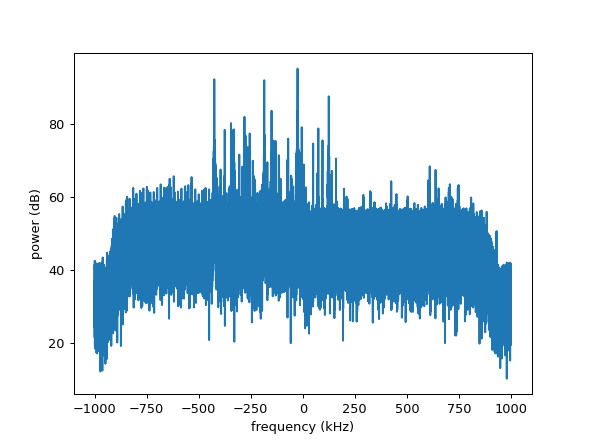

Text(0, 0.5, 'power (dB)')

In [5]:
%matplotlib notebook
freq = np.arange(-samplerate/2,samplerate/2,samplerate/X.shape[-1])/1e3
plt.plot(freq,X)
plt.xlabel("frequency (kHz)")
plt.ylabel("power (dB)")

In the above plot, if you zoom into about 0-50 kHz IF you should see that the noise floor is noticably lower than the surrounding spectrum. This is the VDSL guard band and this feature alone is enough to confidently detect and measure the level of VDSL interference. Per the article though, we will do the correlation to detect the signal structure itself.

## Filtering

Alright, so before we do the delay multiply detection of the cyclic extension in VDSL2 (that last statement should cause you to go click on the referenced article at the top to figure out what the heck it is I am referring to), we need to filter out the high power, narrow band signals so that they don't dominate the relatively short correlations. 

The article doesn't specify exactly how the narrow band signals are identified, so I chose the opening morphological function to find the noise floor. Any signals > 6dB over this level are identified as interferers.

In [6]:
freq_bin = 250
notch_thrsh = 6
len_fft = int(samplerate/freq_bin)
window = sl.hamming(len_fft)
x_f = sl.frame(x,len_fft,int(len_fft/2),pad=False)
x_w = x_f*window

psd = np.fft.fft(x_w)
psd = np.fft.fftshift(np.mean(np.abs(psd),axis=0))
psd = 10*np.log10(psd)

ntaps = 64
psd_o = sl.opening(psd,ntaps)
psd_c = sl.closing(psd,ntaps)

Now lets plot the spectrum, the opening function, and 6dB above that.

<IPython.core.display.Javascript object>


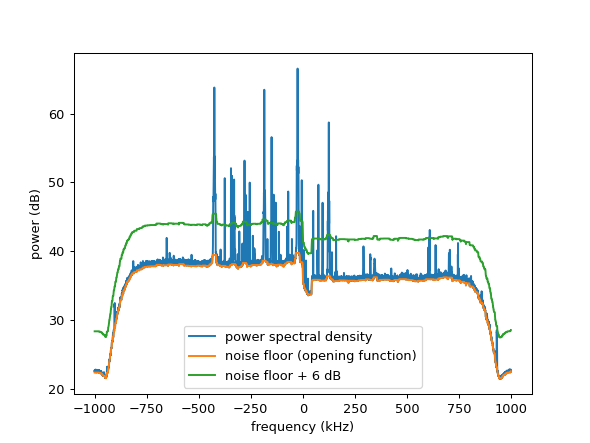

In [7]:
%matplotlib notebook

freq = np.arange(-samplerate/2,samplerate/2,samplerate/psd.shape[-1])/1e3
plt.plot(freq,psd)
plt.plot(freq,psd_o)
plt.plot(freq,psd_o+6)

plt.xlabel("frequency (kHz)")
plt.ylabel("power (dB)")
plt.legend(["power spectral density","noise floor (opening function)","noise floor + 6 dB"])

Now we have a threshold that we can use to get the indecies for a notch filter. I am sure there is a better way to form the filter, but setting the interferer index values to 0, all others to 1, and then IFFTing will give us a crude time domain filter.

In [8]:
H = (psd < (psd_o + notch_thrsh))*1.0
h = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(H)))

Now we need to filter the time domain signal through this filter. To do this you could use scipy.signal.convolve(x,h), but seeing as how the goal here is to gain an understanding of the underlying DSP, (and since I have an astetic preference for numpy only functions), I decided to implement the overlap save correlation in the siglib library. It is pretty low level and so you have to pad and transform the filter, compute how much the overlap should be, and then pass those to the function. Fortunately it is all in the cell below.

In [9]:
overlap = h.shape[-1] - 1
len_fft = int(2**(np.ceil(np.log2(8 * overlap))))
H = np.fft.fft(np.concatenate([h,np.zeros(len_fft-h.shape[-1])]))
step = H.shape[-1] - overlap

x_filt = sl.overlapsave(x,H,step).flatten()

Cool, now lets plot the original and the filtered spectra to make sure our filter worked.

<IPython.core.display.Javascript object>


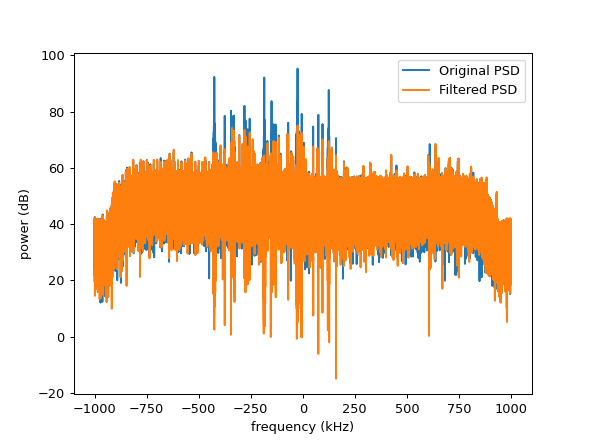

In [10]:
%matplotlib notebook

freq = np.arange(-samplerate/2,samplerate/2,samplerate/x.shape[-1])/1e3
freq_filt = np.arange(-samplerate/2,samplerate/2,samplerate/x_filt.shape[-1])/1e3
plt.plot(freq,10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)))))
plt.plot(freq_filt,10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_filt)))))

plt.xlabel("frequency (kHz)")
plt.ylabel("power (dB)")
plt.legend(["Original PSD","Filtered PSD"])

Now we can perform the shift by the un-extended symbol length of 231 us. Again, there are scipy.signal ways to do this but then we wouldn't be able to understand the ins and outs of sinc interpolation. 

In [11]:
ntaps = 5
symbol_period_sec = 231.884e-6
symbol_period_samp = samplerate*symbol_period_sec
ext_symbol_period_sec = 250e-6
ext_symbol_period_samp = samplerate*ext_symbol_period_sec
ce_len_sec = 18.116e-6
ce_len_samp = int(samplerate*ce_len_sec)

In [12]:
shift_idx = np.arange(symbol_period_samp,x.shape[-1]-np.floor(ntaps/2)-1,1) 

In [13]:
x_shift = sl.resample(x_filt,shift_idx,ntaps)

Now lets take a look at the shifted samples to make sure we know how to do sinc interpolation. Zoom in so you can see a handful of individual samples below and confirm that it looks about right.

<IPython.core.display.Javascript object>


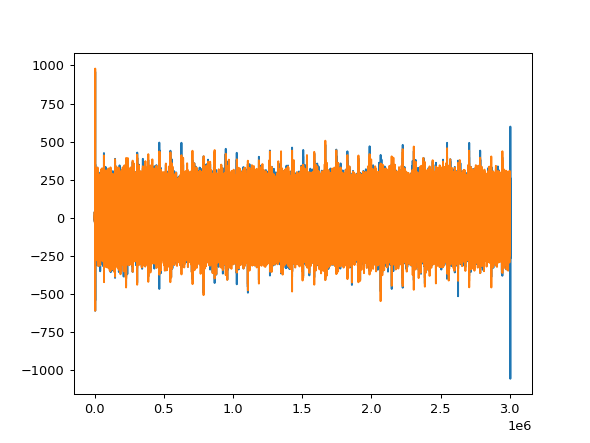

In [14]:
%matplotlib notebook

plt.plot(np.real(x_filt))
plt.plot(shift_idx,np.real(x_shift))

Now we can perform the correlation, the frame_length in the cell below changes how many samples to integrate in the correlation, that might be fun for you to tinker with.

In [15]:
x_xs = x_filt[:x_shift.shape[-1]]*np.conj(x_shift)
x_cor = np.sum(sl.frame(x_xs, frame_length=int(ce_len_samp), frame_step=1,pad=False),axis=-1)

Here we are, we have filtered, we have correlated, now we can plot the correlation in all its glory and see those peaks and ...

<IPython.core.display.Javascript object>


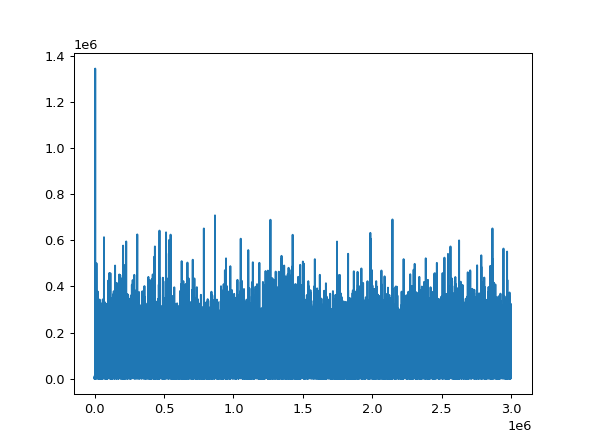

In [16]:
%matplotlib notebook

plt.plot(np.abs(x_cor))

Wa, wa...... Reading further in the article we need to integrate (incoherently) multiple signals to get the peaks to stand out. Furthermore, the article describes pretty well the effect of a SDR clock that drifts and a method to correct it. To do this we will look over -50 PPM to +50 PPM in 5 PPM increments. This can be implemented by slightly shifting the sample that are summed.

In [17]:
svi_cor = []
err_vec = np.arange(-50e-6,55e-6,5e-6)
for samplerate_error in err_vec:
    svi_idx = np.asarray(np.round(np.arange(0,x_cor.shape[-1],1+samplerate_error)),dtype=np.int32)
    svi_idx = sl.frame(svi_idx,1000,1000,pad=False)
    svi_cor.append(np.sum(np.abs(x_cor[svi_idx]),axis=0))
svi_cor = np.array(svi_cor)

In [18]:
err_vec[np.argmax(np.max(svi_cor,axis=-1))]

9.999999999999992e-06

Here we see that the maximum correlation happens at ~10 PPM offset, if we plot the integrated correlation for all of these oscillator errors, it makes for a pretty cool visualization.

<IPython.core.display.Javascript object>


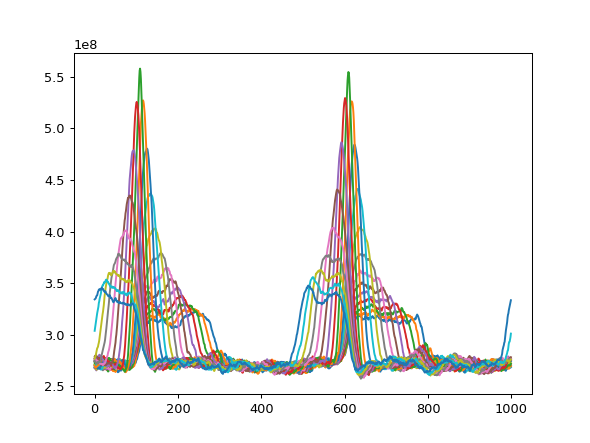

In [19]:
%matplotlib notebook
_ = plt.plot(svi_cor.T)

And there we have it, I still need to add the SNR value of the VDSL signals, but those peaks indicate that we are well on our way to building this analysis notebook out into something pretty cool.